In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/CMPE 255 Project/data/nooa_weather/nooa_nyc_weather_features.csv'
land_station_weather_features = pd.read_csv(path)
land_station_weather_features['Date'] = pd.to_datetime(land_station_weather_features['Date'], infer_datetime_format=True)
# Fills each column's null values with previous value
land_station_weather_features = land_station_weather_features.sort_values('Date').apply(lambda x: x[:x.last_valid_index()].ffill(), axis=0)
land_station_weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...
2095,2020-09-26,233.0,183.0,0.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0
2096,2020-09-27,261.0,194.0,8.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0
2097,2020-09-28,250.0,206.0,5.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0
2098,2020-09-29,233.0,194.0,119.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0


In [4]:
path = '/content/drive/My Drive/CMPE 255 Project/data/nooa_weather/nooa_lightning_data/agg_2011_2020_num_lightning_features.csv'
agg_nyc_lighting_count = pd.read_csv(path)
agg_nyc_lighting_count['Date'] = pd.to_datetime(agg_nyc_lighting_count['Date'], infer_datetime_format=True)
agg_nyc_lighting_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          234 non-null    datetime64[ns]
 1   NumLightning  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB


In [5]:
weather_features = land_station_weather_features.merge(agg_nyc_lighting_count, left_on='Date', right_on='Date', how='left').fillna(0)
weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,0.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0,0.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2020-09-26,233.0,183.0,0.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
2096,2020-09-27,261.0,194.0,8.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
2097,2020-09-28,250.0,206.0,5.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
2098,2020-09-29,233.0,194.0,119.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0


# Common Functions

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

def median_absolute_percentage_error(y_true, y_pred): 
    return np.median(np.abs((y_true - y_pred) / y_true))

# Load ride counts

In [7]:
rides_tmp = []
years = range(2013, 2021)
for y in years:
  path = '/content/drive/My Drive/CMPE 255 Project/data/citibikes/rides_count_agg_{}.csv'.format(y)
  rides_y = pd.read_csv(path)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)
rides['date'] = pd.to_datetime(rides['date'], infer_datetime_format=True)
rides = rides[rides.date < '2020-03-01']
rides

,date,usertype,numrides
0,2013-07-01,Customer,0
1,2013-07-01,Subscriber,13916
2,2013-07-02,Customer,2
3,2013-07-02,Subscriber,18672
4,2013-07-03,Customer,3
...,...,...,...
115,2020-02-27,Subscriber,40628
116,2020-02-28,Customer,1593
117,2020-02-28,Subscriber,39944
118,2020-02-29,Customer,1793


In [8]:
rides = rides.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
rides = rides.fillna(rides.mean())
rides

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,2020-02-27,Subscriber,40628,61.0,-5.0,102.0,0.0,57.0,0.0,280.0,290.0,125.0,197.0,0.0
3340,2020-02-28,Customer,1593,56.0,-16.0,0.0,0.0,44.0,0.0,270.0,230.0,94.0,152.0,0.0
3341,2020-02-28,Subscriber,39944,56.0,-16.0,0.0,0.0,44.0,0.0,270.0,230.0,94.0,152.0,0.0
3342,2020-02-29,Customer,1793,17.0,-38.0,0.0,0.0,39.0,0.0,300.0,330.0,81.0,134.0,0.0


In [9]:
subscriber_rides = rides[rides['usertype'] == 'Subscriber']
subscriber_rides = subscriber_rides.rename(columns={'date':'ds', 'numrides':'y'})

customer_rides = rides[(rides['usertype'] == 'Customer') & (rides['date'] >= '2016-01-01')]
customer_rides = customer_rides.rename(columns={'date':'ds', 'numrides':'y'})

subscriber_rides

,ds,usertype,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,0.0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,0.0
5,2015-01-03,Subscriber,4252,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,0.0
7,2015-01-04,Subscriber,7456,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0,0.0
9,2015-01-05,Subscriber,14256,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,2020-02-25,Subscriber,37032,117.0,78.0,36.0,0.0,17.0,0.0,60.0,220.0,54.0,76.0,0.0
3337,2020-02-26,Subscriber,42252,89.0,61.0,0.0,0.0,32.0,0.0,100.0,120.0,63.0,103.0,0.0
3339,2020-02-27,Subscriber,40628,61.0,-5.0,102.0,0.0,57.0,0.0,280.0,290.0,125.0,197.0,0.0
3341,2020-02-28,Subscriber,39944,56.0,-16.0,0.0,0.0,44.0,0.0,270.0,230.0,94.0,152.0,0.0


In [10]:
holdout_period = 365

max_date = subscriber_rides[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = subscriber_rides.loc[subscriber_rides.ds <= split_date].copy()
test = subscriber_rides.loc[subscriber_rides.ds > split_date].copy()
print(split_date)

2019-03-01


# Ride Count Forecasting

In [19]:
X_train = train.drop(['ds', 'usertype', 'y'], axis=1)
y_train = train['y']
X_test = test.drop(['ds', 'usertype', 'y'], axis=1)
y_test = test['y']

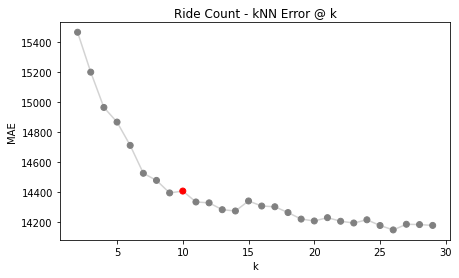

In [20]:
errors = [] #to store rmse values for different k
trial_ks = range(2, 30)
for i in trial_ks:
  K = i+1
  model = KNeighborsRegressor(n_neighbors = K, metric='euclidean')
  model.fit(X_train, y_train)
  pred=model.predict(X_test)
  error = mean_absolute_error(y_test,pred)
  errors.append(error)

plt.figure(figsize=(7, 4))
plt.plot(trial_ks, errors, 'lightgrey', zorder=-1)
plt.scatter(trial_ks, errors, c=['red' if i == 10 else 'grey' for i in trial_ks])
plt.xlabel('k')
plt.ylabel('MAE')
plt.title('Ride Count - kNN Error @ k')
plt.show()

In [21]:
k = 10
neigh = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
neigh.fit(X_train, y_train)

predictions = neigh.predict(X_test)

In [22]:
# Error for 180 day horizon

print(mean_absolute_error(y_test[:181], predictions[:181]))
print(mean_absolute_percentage_error(y_test[:181], predictions[:181]))
print(median_absolute_percentage_error(y_test[:181], predictions[:181]))

14625.495580110495
0.2660619815811936
0.278004675081814


In [23]:
# Error for 365 day horizon

print(mean_absolute_error(y_test, predictions))
print(mean_absolute_percentage_error(y_test, predictions))
print(median_absolute_percentage_error(y_test, predictions))

14395.202739726028
0.2889943244909174
0.2856638052245985


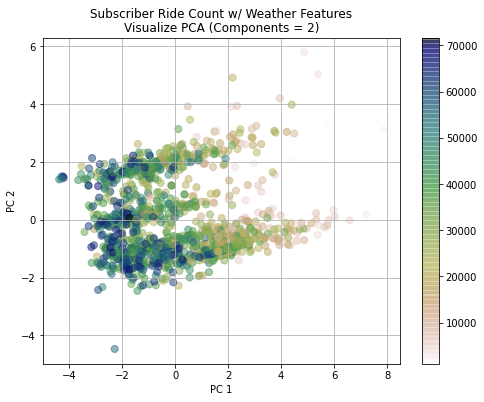

In [29]:
X = train.drop(['ds', 'usertype', 'y'], axis=1)
y = train[['y']]

mm_scaler = preprocessing.StandardScaler()
X_scaled = mm_scaler.fit_transform(X)

pca = PCA(n_components=2) 
principalComponents = pca.fit_transform(X_scaled) 
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1','principal component 2']) 
finalDf = principalDf.merge(pd.DataFrame(y, columns=['y']).reset_index(), left_index=True, right_index=True)
finalDf

f, ax = plt.subplots(figsize=(8,6))
plt.title('Subscriber Ride Count w/ Weather Features\nVisualize PCA (Components = 2)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
points = ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['y'], s=50, cmap='gist_earth_r', alpha=0.5)
ax.grid()
f.colorbar(points)

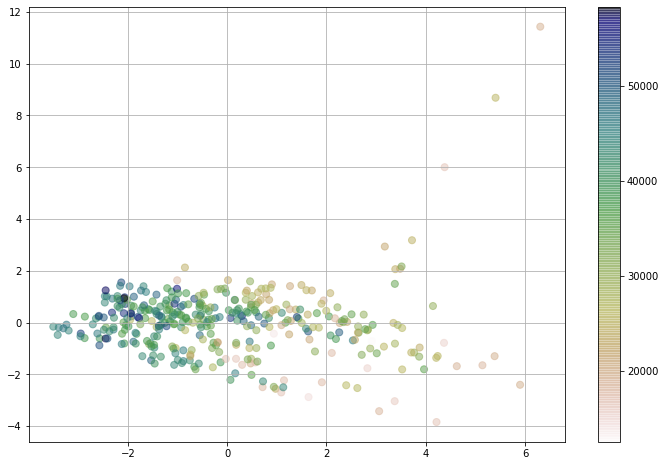

In [ ]:
predictions_df = pd.DataFrame(neigh.predict(X), columns=['pred'])
df = principalDf.merge(predictions_df, left_index=True, right_index=True)
df

f, ax = plt.subplots(figsize=(12,8))
points = ax.scatter(df['principal component 1'], df['principal component 2'], c=df['pred'], s=50, cmap='gist_earth_r', alpha=0.5)
ax.grid()
f.colorbar(points)

# Bike Accident Forecasting

In [30]:
path = '/content/drive/My Drive/CMPE 255 Project/data/bike_accidents/accident_count_agg.csv'
num_bike_collisions = pd.read_csv(path)
num_bike_collisions['date'] = pd.to_datetime(num_bike_collisions['date'], infer_datetime_format=True)
num_bike_collisions

,date,num_crashes
0,2016-03-08,2
1,2016-03-09,1
2,2016-03-11,1
3,2016-03-12,2
4,2016-03-13,5
...,...,...
1674,2020-10-09,27
1675,2020-10-10,13
1676,2020-10-11,17
1677,2020-10-12,13


In [31]:
num_bike_collisions = num_bike_collisions.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
num_bike_collisions = num_bike_collisions.fillna(num_bike_collisions.mean())
num_bike_collisions = num_bike_collisions.rename(columns={'date':'ds', 'num_crashes':'y'})
num_bike_collisions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,NumLightning
0,2016-03-08,2,194.0,83.0,0.0,0.0,15.0,0.0,170.0,170.0,63.0,85.0,0.0
1,2016-03-09,1,250.0,67.0,0.0,0.0,10.0,0.0,240.0,210.0,45.0,98.0,0.0
2,2016-03-11,1,200.0,89.0,15.0,0.0,27.0,0.0,40.0,10.0,76.0,116.0,0.0
3,2016-03-12,2,150.0,44.0,0.0,0.0,23.0,0.0,250.0,250.0,67.0,103.0,0.0
4,2016-03-13,5,167.0,100.0,0.0,0.0,16.0,0.0,30.0,30.0,54.0,81.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,2020-09-26,17,233.0,183.0,0.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
1662,2020-09-27,31,261.0,194.0,8.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
1663,2020-09-28,23,250.0,206.0,5.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0
1664,2020-09-29,21,233.0,194.0,119.0,0.0,12.0,0.0,250.0,230.0,40.0,85.0,0.0


In [32]:
holdout_period = 365

max_date = num_bike_collisions[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(split_date)

2019-10-01


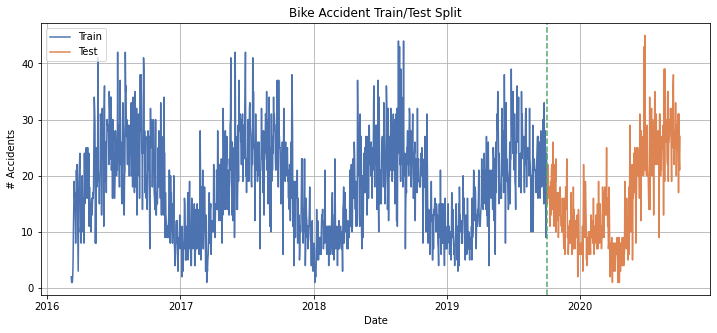

In [33]:
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x='ds', y='y', label='Train', data=train, ax=ax, color=sns_c[0])
sns.lineplot(x='ds', y='y', label='Test', data=test, ax=ax, color=sns_c[1])
ax.axvline(pd.to_datetime(split_date), color=sns_c[2], linestyle='--')
ax.legend(loc='upper left')
ax.grid(True)
ax.set(title='Bike Accident Train/Test Split', xlabel='Date', ylabel='# Accidents');

In [34]:
X_train = train.drop(['ds', 'y'], axis=1)
y_train = train['y']
X_test = test.drop(['ds', 'y'], axis=1)
y_test = test['y']

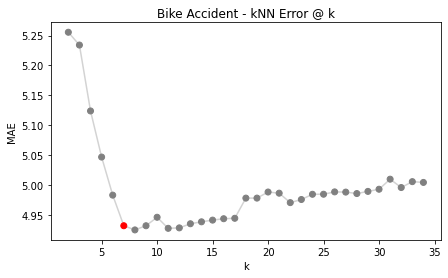

In [40]:
errors = [] #to store rmse values for different k
trial_ks = range(2, 35)
for i in trial_ks:
  K = i+1
  model = KNeighborsRegressor(n_neighbors = K, metric='euclidean')
  model.fit(X_train, y_train)
  pred=model.predict(X_test)
  error = mean_absolute_error(y_test,pred)
  errors.append(error)

plt.figure(figsize=(7, 4))
plt.plot(trial_ks, errors, 'lightgrey', zorder=-1)
plt.scatter(trial_ks, errors, c=['red' if i == 7 else 'grey' for i in trial_ks])
plt.xlabel('k')
plt.ylabel('MAE')
plt.title('Bike Accident - kNN Error @ k')
plt.show()

In [41]:
k = 7
neigh = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
neigh.fit(X_train, y_train)

predictions = neigh.predict(X_test)

In [42]:
# Error for 180 day horizon

print(mean_absolute_error(y_test[:181], predictions[:181]))
print(mean_absolute_percentage_error(y_test[:181], predictions[:181]))
print(median_absolute_percentage_error(y_test[:181], predictions[:181]))

3.6779794790844518
0.46715957122426255
0.28571428571428575


In [43]:
# Error for 365 day horizon

print(mean_absolute_error(y_test, predictions))
print(mean_absolute_percentage_error(y_test, predictions))
print(median_absolute_percentage_error(y_test, predictions))

4.982778864970645
0.5861145799681572
0.2678571428571429
